In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import math
import heapq #used to implement priority queue in STEP 3

### STEP 1: Random Placement<br>
Takes random patches of fixed size `patchLength` from the sample image<br>
and tiles them next to each other to form an output texture.

In [2]:
def randomPatch(texture, patchLength):
    h, w, _ = texture.shape
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]

### STEP 2: Overlap Boundaries<br>
Computes the L² error between a candidate patch and the overlapping regions of the current output texture.

In [3]:
def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0

    #computes the difference between the left overlapping region of the patch and the corresponding region in the output texture
    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    #computes the difference between the top overlapping region of the patch and the corresponding region in the output texture.
    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    #subtracts the squared sum of the corner overlap differences to avoid double-counting the overlapping area.
    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

Selects the best patch from the sample image based on the lowest L² overlap difference, ensuring the new patch blends seamlessly with the existing texture.

In [4]:
def randomBestPatch(texture, patchLength, overlap, res, y, x):
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]

### STEP 3: Minimum Error Cut<br>

for the overlapped image taken from STEP 2, it implements Dijkstra's algorithm to compute the minimum cumulative error path across a 2D errors matrix.<br>
Reduces visual seams between patches.<br>

In [5]:
def minCutPath(errors):
    # Dijkstra's algorithm for vertical min-cut path
    pq = [(error, [i]) for i, error in enumerate(errors[0])]
    heapq.heapify(pq)

    h, w = errors.shape
    seen = set()

    while pq:
        error, path = heapq.heappop(pq)
        curDepth = len(path)
        curIndex = path[-1]

        if curDepth == h:
            return path

        for delta in -1, 0, 1:
            nextIndex = curIndex + delta

            if 0 <= nextIndex < w:
                if (curDepth, nextIndex) not in seen:
                    cumError = error + errors[curDepth, nextIndex]
                    heapq.heappush(pq, (cumError, path + [nextIndex]))
                    seen.add((curDepth, nextIndex))

Computes and applies a minimum error cut between the current patch and the overlapping region in the output texture

In [6]:
def minCutPatch(patch, patchLength, overlap, res, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    minCut = np.zeros_like(patch, dtype=bool)

    if x > 0:
        left = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        leftL2 = np.sum(left**2, axis=2)
        for i, j in enumerate(minCutPath(leftL2)):
            minCut[i, :j] = True

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        upL2 = np.sum(up**2, axis=2)
        for j, i in enumerate(minCutPath(upL2.T)):
            minCut[:i, j] = True

    np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut)

    return patch

### Image Quilting
Implments image quilting based on mode (`random`, `best` anf `cut`) for Random Rlacement, Rverlap RBundaries and Minimum Error Cut.

In [7]:
def quilt(texture, patchLength, numPatches, mode="cut", sequence=False):
    texture = texture.astype(np.float32) / 255.0  #Convert to float32 for processing

    overlap = patchLength // 6
    numPatchesHigh, numPatchesWide = numPatches

    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    res = np.zeros((h, w, texture.shape[2]))

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(texture, patchLength)
            elif mode == "best":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x)

            res[y:y+patchLength, x:x+patchLength] = patch

            if sequence:
                cv2.imshow("Intermediate Result", res)
                cv2.waitKey(1)

    return (res * 255).astype(np.uint8)  #Convert back to uint8 for displaying

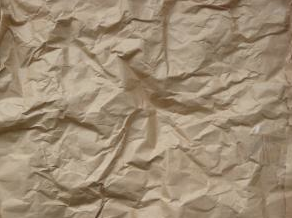

In [8]:
texture = cv2.imread("/content/input_47.png")
cv2_imshow(texture)

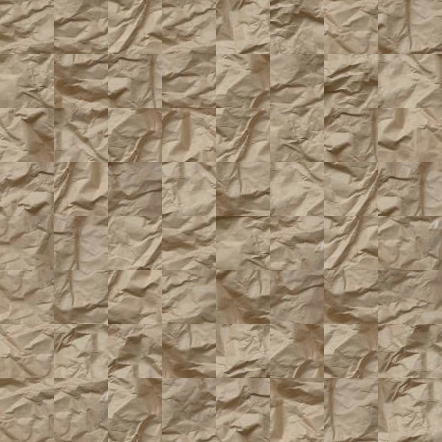

In [9]:
cv2_imshow(quilt(texture, 64, (8, 8), "random"))

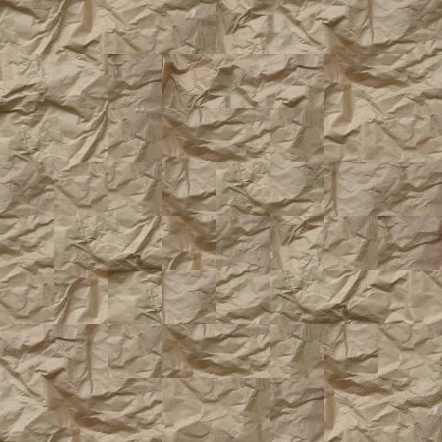

In [10]:
cv2_imshow(quilt(texture, 64, (8, 8), "best"))

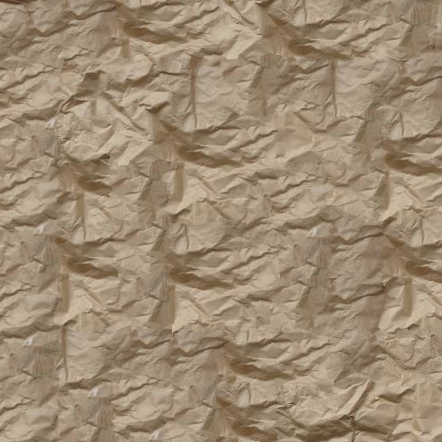

In [11]:
cv2_imshow(quilt(texture, 64, (8, 8), "cut"))